In [100]:
# general
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import time

# modelling
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.linear_model import LinearRegression,lars_path,LassoCV,RidgeCV, ElasticNet
from sklearn import linear_model
from sklearn import metrics
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score, max_error, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesRegressor

In [101]:
def choose_csv():
    '''
    Returns the dataset you chose. 

    '''
    data_counts = pd.read_csv('data/listings_cleaned_with_counts.csv', index_col=['id'])
    
    data_all = pd.read_csv('data/listings.csv',index_col=['id'])
    data_all = data_all.loc[data_counts.index]
    
    data_raw = pd.read_csv('data/listings_cleaned.csv',index_col=['id'])
    
    return data_counts, data_all, data_raw

In [102]:
def drop():
    data_counts, data_all, data_raw = choose_csv()
    
    if input('Do you want to drop columns? (y/n)') == 'y':
        print(list(data_counts))
        to_drop = []
        to_drop.append(input('Enter Column Name: '))
        while input('Do you want to drop more columns? (y/n)  ') == 'y':
            to_drop.append(input('Enter Column Name: '))
        data_counts = data_counts.drop(columns = to_drop)
        if input("Do you want to drop the columns permanently? (y/n) ") == 'y':
            data_counts.to_csv('data/listings_cleaned_with_counts.csv')   
    
            
    if input('Do you want to include categorical data? (y/n) : ') == 'y':
        cols = ['neighbourhood_cleansed','property_type','room_type','bed_type','cancellation_policy']
        cat_cols = data_all[cols]
        
        threshold_percent = 10
        series = pd.value_counts(cat_cols['property_type'])
        mask = (series / series.sum() * 100).lt(threshold_percent)
        cat_cols = cat_cols.assign(property_type = np.where(cat_cols['property_type'].isin(series[mask].index),'Other', cat_cols['property_type']))
        
        data_for_modeling = pd.concat([data_counts, cat_cols], axis=1)
        data_for_modeling = pd.get_dummies(data_for_modeling)
        data_for_modeling.columns = data_for_modeling.columns.str.replace(' ','_')
    else: 
        data_for_modeling = data_counts
    
    
    missing = input('How do you want to handle the missing data? (drop/impute/0s) : ')
    if missing == 'drop':
        data_for_modeling = data_for_modeling.dropna()
    elif missing == '0s':
        data_for_modeling = data_for_modeling.fillna(0)
    else:
        from sklearn.experimental import enable_iterative_imputer
        from sklearn.impute import IterativeImputer
        imp = IterativeImputer(max_iter=10, random_state=0, tol=0.01)
        data_for_modeling_imp = imp.fit_transform(data_for_modeling)
        data_for_modeling = pd.DataFrame(data_for_modeling_imp, columns = data_for_modeling.columns)
    
    return data_for_modeling, data_counts, data_raw

In [103]:
def linreg(X_train, X_test, y_train, y_test):
    lin_reg = LinearRegression()  
    lin_reg.fit(X_train, y_train)
    y_train_pred = lin_reg.predict(X_train)
    y_test_pred = lin_reg.predict(X_test)
    train_score = round(r2_score(y_train, y_train_pred),4)
    test_score = round(r2_score(y_test, y_test_pred),4)
    print("Linear Regression")
    print("\nTraining r2:", train_score) 
    print("Validation r2:", test_score)

In [104]:
def lasso(X_train, X_test, y_train, y_test):
    alphas = 10**np.linspace(-2,2,200)
    lasso = LassoCV(alphas=alphas,cv=10,tol=0.1).fit(X_train, y_train)
    y_train_pred = lasso.predict(X_train)
    y_test_pred = lasso.predict(X_test)
    train_score = round(r2_score(y_train, y_train_pred),4)
    test_score = round(r2_score(y_test, y_test_pred),4)
    print("Lasso Regression")
    print("\nTraining r2:", train_score)
    print("Validation r2:", test_score)

In [105]:
def ridge(X_train, X_test, y_train, y_test):
    alphas = np.linspace(0,2,100)
    ridge = RidgeCV(normalize=False,alphas=alphas,cv=10).fit(X_train, y_train) 
    y_train_pred = ridge.predict(X_train)
    y_test_pred = ridge.predict(X_test)
    train_score = round(r2_score(y_train, y_train_pred),4)
    test_score = round(r2_score(y_test, y_test_pred),4)
    print("Ridge Regression")
    print("\nTraining r2:", train_score)
    print("Validation r2:", test_score)

In [106]:
def poly_lasso(X_train, X_test, y_train, y_test):
    poly = PolynomialFeatures(degree=2).fit(X_train)
    X_train_poly = poly.transform(X_train) 
    X_test_poly = poly.transform(X_test)
    alphas = 10**np.linspace(-2,2,100)
    lasso = LassoCV(alphas=alphas,cv=5,tol=0.5).fit(X_train_poly, y_train.ravel()) 
    y_train_pred = lasso.predict(X_train_poly)
    y_test_pred = lasso.predict(X_test_poly)
    train_score = round(r2_score(y_train, y_train_pred),4)
    test_score = round(r2_score(y_test, y_test_pred),4)
    print("Lasso Regression with Polynomial Features")
    print("\nTraining r2:", train_score)
    print("Validation r2:", test_score)

In [107]:
def poly_ridge(X_train, X_test, y_train, y_test):
    poly = PolynomialFeatures(degree=2).fit(X_train)
    X_train_poly = poly.transform(X_train) 
    X_test_poly = poly.transform(X_test)
    alphas = 10**np.linspace(-2,2,100)
    ridge = RidgeCV(normalize=True,alphas=alphas,cv=5,).fit(X_train_poly, y_train.ravel()) 
    y_train_pred = ridge.predict(X_train_poly)
    y_test_pred = ridge.predict(X_test_poly)
    train_score = round(r2_score(y_train, y_train_pred),4)
    test_score = round(r2_score(y_test, y_test_pred),4)
    print("Ridge Regression with Polynomial Features")
    print("\nTraining r2:", train_score)
    print("Validation r2:", test_score)

In [108]:
def boost(X_train, X_test, y_train, y_test):
    xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.4, learning_rate = 0.15, max_depth = 4, booster='gbtree')
    xg_reg.fit(X_train,y_train)
    y_train_pred = xg_reg.predict(X_train)
    y_test_pred = xg_reg.predict(X_test)
    train_score = round(r2_score(y_train, y_train_pred),4)
    test_score = round(r2_score(y_test, y_test_pred),4)
    print("XGBoost")
    print("\nTraining r2:", train_score)
    print("Validation r2:", test_score)
    fig, ax = plt.subplots(figsize=(20, 10))
    plot_importance(xg_reg, ax=ax)
    #pyplot.show()

In [109]:
data_for_modeling, data, data_raw = drop()

Do you want to drop columns? (y/n) n
Do you want to include categorical data? (y/n) :  y
How do you want to handle the missing data? (drop/impute/0s) :  impute


In [110]:
data_for_modeling

,accommodates,bathrooms,price,minimum_nights,maximum_nights,availability_30,number_of_reviews,number_of_reviews_ltm,restaurants,bars,...,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out_Sofa,bed_type_Real_Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60
0,2.0,1.0,59.0,14.0,60.0,0.0,4.0,2.0,161.0,50.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,1.0,1.0,55.0,2.0,90.0,22.0,178.0,30.0,19.0,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,7.0,1.0,117.0,2.0,60.0,0.0,394.0,27.0,7.0,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,2.0,1.0,80.0,2.0,60.0,29.0,384.0,48.0,131.0,44.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,4.0,1.0,150.0,4.0,180.0,4.0,49.0,16.0,84.0,40.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8346,2.0,1.0,65.0,1.0,1125.0,14.0,0.0,0.0,40.0,6.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
8347,15.0,3.0,200.0,1.0,1125.0,28.0,0.0,0.0,47.0,26.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
8348,4.0,1.0,63.0,1.0,1125.0,24.0,0.0,0.0,64.0,20.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
8349,4.0,1.5,75.0,3.0,30.0,26.0,0.0,0.0,55.0,46.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


## Data without new variables and without categorical features


In [111]:
X = data_raw.drop('price', axis=1)
y = data_raw.price
scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)
#ey_scaled = scaler.fit_transform(y.values.reshape(-1,1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [112]:
linreg(X_train, X_test, y_train, y_test)

Linear Regression

Training r2: 0.394
Validation r2: 0.3185


In [113]:
lasso(X_train, X_test, y_train, y_test)

Lasso Regression

Training r2: 0.394
Validation r2: 0.3186


In [114]:
ridge(X_train, X_test, y_train, y_test)

Ridge Regression

Training r2: 0.394
Validation r2: 0.3186


In [115]:
poly_lasso(X_train, X_test, y_train, y_test)

Lasso Regression with Polynomial Features

Training r2: 0.4207
Validation r2: 0.3411


In [116]:
#poly_ridge(X_train, X_test, y_train, y_test)

XGBoost

Training r2: 0.7236
Validation r2: 0.5275


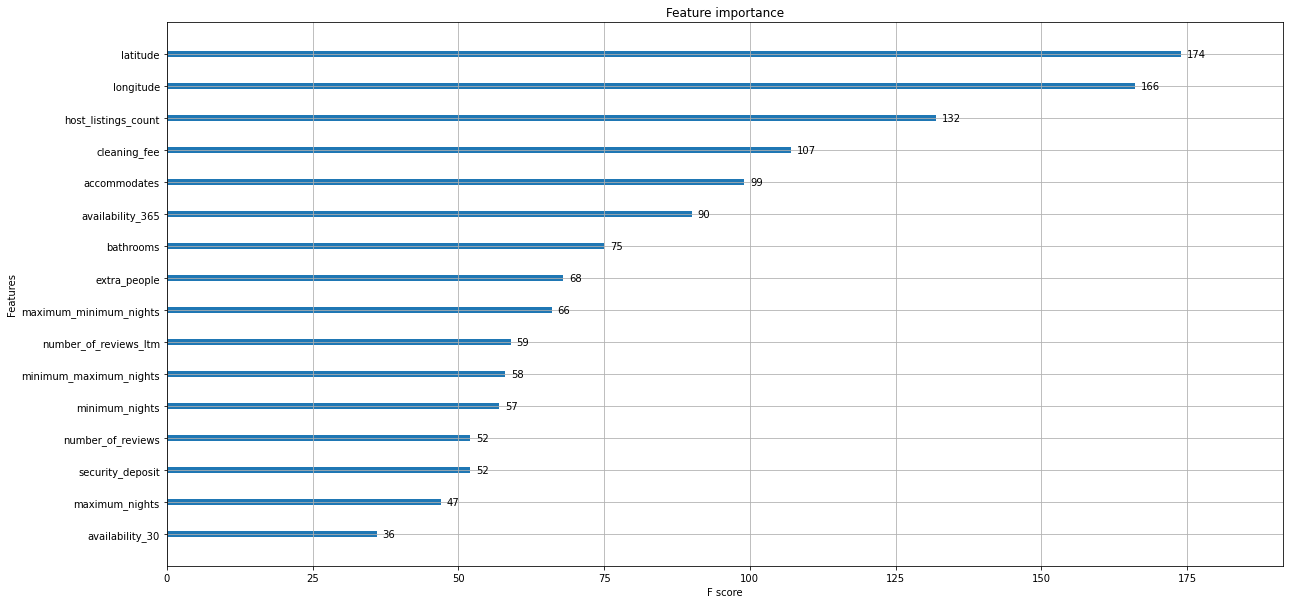

In [117]:
boost(X_train, X_test, y_train, y_test)

## Data with new variables 

In [118]:
X = data_for_modeling.drop('price', axis=1)
y = data_for_modeling.price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [119]:
linreg(X_train, X_test, y_train, y_test)

Linear Regression

Training r2: 0.4325
Validation r2: 0.4904


In [120]:
lasso(X_train, X_test, y_train, y_test)

Lasso Regression

Training r2: 0.431
Validation r2: 0.4891


In [121]:
ridge(X_train, X_test, y_train, y_test)

Ridge Regression

Training r2: 0.4324
Validation r2: 0.4901


In [122]:
poly_lasso(X_train, X_test, y_train, y_test)

Lasso Regression with Polynomial Features

Training r2: 0.5098
Validation r2: 0.5357


In [123]:
#poly_ridge(X_train, X_test, y_train, y_test)

XGBoost

Training r2: 0.653
Validation r2: 0.601


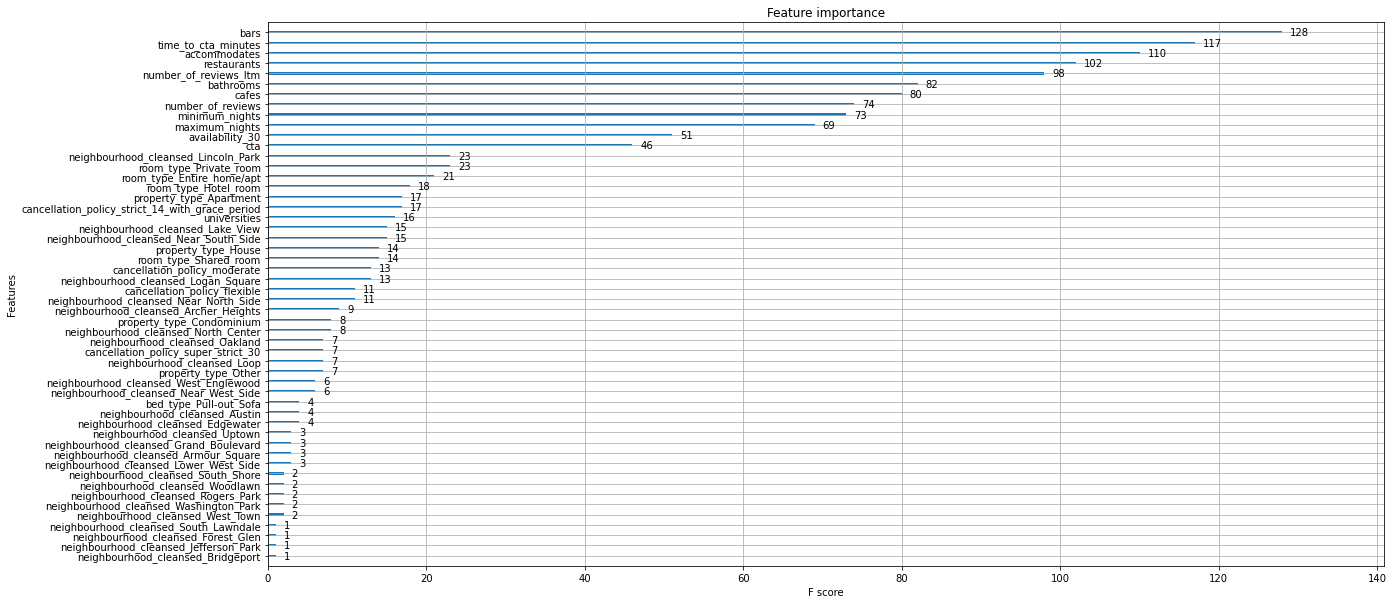

In [124]:
boost(X_train, X_test, y_train, y_test)

In [125]:
list(data)

['accommodates',
 'bathrooms',
 'price',
 'minimum_nights',
 'maximum_nights',
 'availability_30',
 'number_of_reviews',
 'number_of_reviews_ltm',
 'restaurants',
 'bars',
 'cafes',
 'universities',
 'cta',
 'time_to_cta_minutes']